In [1]:
import torch
torch.cuda.set_device(4)
print(torch.cuda.current_device())

4


In [2]:
%run ../../prepare_data.py
%run ../../architectures.py

In [3]:
batch_size = 32

In [4]:
train_loader, valid_loader, valid_dataset = rsna_dataloaders(batch_size)

In [5]:
x, y = next(iter(train_loader))

In [6]:
x.shape, y.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [7]:
model = resnet18().cuda()

In [8]:
sum(p.numel() for p in model.parameters())

11177025

CPU times: user 47.3 s, sys: 10.9 s, total: 58.2 s
Wall time: 58.6 s


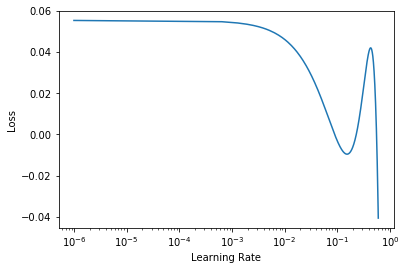

In [9]:
%%time
lrs, losses = LR_range_finder(model, train_loader, 
                              loss_fn=F.binary_cross_entropy_with_logits, 
                              binary=True, lr_high=0.6)
plot_lr(lrs, losses)

# Training

In [11]:
widths = [1.0, 0.75, 0.5, 0.25]
depths = [[[[64, 2], [128, 2]], [[256, 2], [512, 1]]],
          [[[64, 2], [128, 2]], [[256, 1], [512, 1]]],
          [[[64, 2], [128, 1]], [[256, 1], [512, 1]]],
          [[[64, 2], [128, 1]], [[256, 2], [512, 1]]],
          [[[64, 1], [128, 1]], [[256, 2], [512, 1]]],
          [[[64, 1], [128, 1]], [[256, 1], [512, 1]]],
         ]

In [ ]:
data = []

for w in widths:
    for d in depths:
        d_s = sum(j[1] for i in d for j in i)
        print('width multiplier - %.3f depth multiplier - %.3f' % (w, d_s))
        model = resnet18(width_mult=w, 
                         inverted_residual_setting1=d[0], 
                         inverted_residual_setting2=d[1]).cuda()
        
        p = sum(p.numel() for p in model.parameters())
        optimizer = create_optimizer(model, 0.1)
        score, t = train_triangular_policy(model, optimizer, train_loader, valid_loader, valid_dataset,
                                           loss_fn=F.binary_cross_entropy_with_logits, 
                                           dataset='rsna', binary=True, max_lr=0.1, epochs=15)
        data.append([w, d_s, score, p, t])
        print('')

width multiplier - 1.000 depth multiplier - 7.000
train_loss 0.027 val_loss 31.942 val_auc_score 0.435
----End of step 0:01:24.823345
train_loss 0.174 val_loss 41.236 val_auc_score 0.421
----End of step 0:01:25.186160
train_loss 0.457 val_loss 162.258 val_auc_score 0.421
----End of step 0:01:26.109637
train_loss 1.757 val_loss 592.000 val_auc_score 0.363
----End of step 0:01:26.904425
train_loss 2.868 val_loss 628.369 val_auc_score 0.396
----End of step 0:01:25.992702
train_loss 5.038 val_loss 515.223 val_auc_score 0.318
----End of step 0:01:25.170020
train_loss 3.163 val_loss 331.005 val_auc_score 0.315
----End of step 0:01:25.606591
train_loss 1.697 val_loss 172.171 val_auc_score 0.383
----End of step 0:01:25.658898
train_loss 1.308 val_loss 159.366 val_auc_score 0.399
----End of step 0:01:25.694892
train_loss 0.765 val_loss 2433.362 val_auc_score 0.424
----End of step 0:01:26.092601
train_loss 0.798 val_loss 179.396 val_auc_score 0.367
----End of step 0:01:26.319826
train_loss 0.371

train_loss 0.828 val_loss 119.223 val_auc_score 0.601
----End of step 0:01:19.393838
train_loss 2.759 val_loss 418.204 val_auc_score 0.309
----End of step 0:01:19.955677
train_loss 3.320 val_loss 398.376 val_auc_score 0.380
----End of step 0:01:18.398295
train_loss 2.645 val_loss 323.529 val_auc_score 0.374
----End of step 0:01:18.571757
train_loss 1.258 val_loss 18.580 val_auc_score 0.480
----End of step 0:01:18.540823
train_loss 0.347 val_loss 72.087 val_auc_score 0.430
----End of step 0:01:15.730354
train_loss 0.704 val_loss 19.446 val_auc_score 0.727
----End of step 0:01:15.498488
train_loss 0.203 val_loss 10.198 val_auc_score 0.663
----End of step 0:01:14.949137
train_loss 0.176 val_loss 8.906 val_auc_score 0.553
----End of step 0:01:15.063043
train_loss 0.120 val_loss 5.425 val_auc_score 0.626
----End of step 0:01:15.004644
train_loss 0.127 val_loss 4.351 val_auc_score 0.640
----End of step 0:01:16.304456
train_loss 0.143 val_loss 3.876 val_auc_score 0.546
----End of step 0:01:19

In [ ]:
columns = ['width_x', 'depth_x', 'val_score', 'params', 'time_per_epoch']
df = pd.DataFrame(data=data, columns=columns)

In [ ]:
df.to_csv("rsna_resnet.csv", index=False)

In [ ]:
df_re = pd.read_csv('rsna_resnet.csv')

In [ ]:
df_re.head()